In [1]:
import os
import subprocess
from time import time
from pathlib import Path
import shutil

def benchmark_compression(
    compress_cmd: str,
    decompress_cmd: str,
    original_file: str,
    compressed_file: str,
    decompressed_file: str
) -> tuple[float, float, float]:
    """
    Benchmark the runtime and compression ratio of the compressor.
    Returns a tuple of (compression ratio, compress time, decompress time)."""
    print(f"\nCompressing: {original_file}")
    print(f"Running: {compress_cmd}")
    t0 = time()
    subprocess.run(compress_cmd, shell=True)
    compress_time = time() - t0
    print(f"Compression time: {compress_time} sec")

    print(f"Running: {decompress_cmd}")
    t0 = time()
    subprocess.run(decompress_cmd, shell=True)
    decompress_time = time() - t0
    print(f"Decompression time: {decompress_time} sec")

    with open(original_file, "rb") as f:
        original = f.read()
    with open(decompressed_file, "rb") as f:
        decompressed = f.read()
    assert original == decompressed, "original doesn't match decompressed"

    original_size = os.path.getsize(original_file)
    compressed_size = os.path.getsize(compressed_file)
    compression_ratio = original_size / compressed_size
    print(f"Original size: {original_size} bytes")
    print(f"Compressed size: {compressed_size} bytes")
    print(f"Compression ratio: {compression_ratio}")

    os.remove(compressed_file)
    os.remove(decompressed_file)

    return compression_ratio, compress_time, decompress_time


def benchmark_my_compression(original_file: str, binary: bool) -> tuple[float, float, float]:
    compress_cmd = f"python3 bwt_huffman.py -c -i {original_file} -o compressed.huff"
    decompress_cmd = f"python3 bwt_huffman.py -d -i compressed.huff -o decompressed.txt"
    if binary:
        compress_cmd += " -b"
        decompress_cmd += " -b"
    return benchmark_compression(compress_cmd, decompress_cmd, original_file, "compressed.huff", "decompressed.txt")

def benchmark_zip(original_file: str) -> tuple[float, float, float]:
    compress_cmd = f"zip compressed.zip {original_file}"
    decompress_cmd = f"unzip compressed.zip -d zip_tmp"
    bench_out = benchmark_compression(compress_cmd, decompress_cmd, original_file, "compressed.zip", f"zip_tmp/{original_file}")
    shutil.rmtree("zip_tmp")
    return bench_out

def benchmark_bzip2(original_file: str) -> tuple[float, float, float]:
    compress_cmd = f"bzip2 {original_file} -k -c > bz2_file.txt.bz2"
    decompress_cmd = "bunzip2 bz2_file.txt.bz2 -k"
    return benchmark_compression(compress_cmd, decompress_cmd, original_file, "bz2_file.txt.bz2", "bz2_file.txt")

def benchmark_gzip(original_file: str) -> tuple[float, float, float]:
    compress_cmd = f"gzip {original_file} -k -c > gz_file.txt.gz"
    decompress_cmd = "gunzip gz_file.txt.gz -k"
    return benchmark_compression(compress_cmd, decompress_cmd, original_file, "gz_file.txt.gz", "gz_file.txt")


Compressing: test_data/karpathy_shakespeare.txt
Running: python3 bwt_huffman.py -c -i test_data/karpathy_shakespeare.txt -o compressed.huff
Compression time: 4.955719709396362 sec
Running: python3 bwt_huffman.py -d -i compressed.huff -o decompressed.txt
Decompression time: 1.847186803817749 sec
Original size: 1115393 bytes
Compressed size: 381367 bytes
Compression ratio: 2.924723429137812

Compressing: test_data/karpathy_shakespeare.txt
Running: bzip2 test_data/karpathy_shakespeare.txt -k -c > bz2_file.txt.bz2
Compression time: 0.1066138744354248 sec
Running: bunzip2 bz2_file.txt.bz2 -k
Decompression time: 0.055431365966796875 sec
Original size: 1115393 bytes
Compressed size: 328486 bytes
Compression ratio: 3.395557192696188

Compressing: test_data/karpathy_shakespeare.txt
Running: zip compressed.zip test_data/karpathy_shakespeare.txt
  adding: test_data/karpathy_shakespeare.txt (deflated 61%)
Compression time: 0.11021614074707031 sec
Running: unzip compressed.zip -d zip_tmp
Archive: 

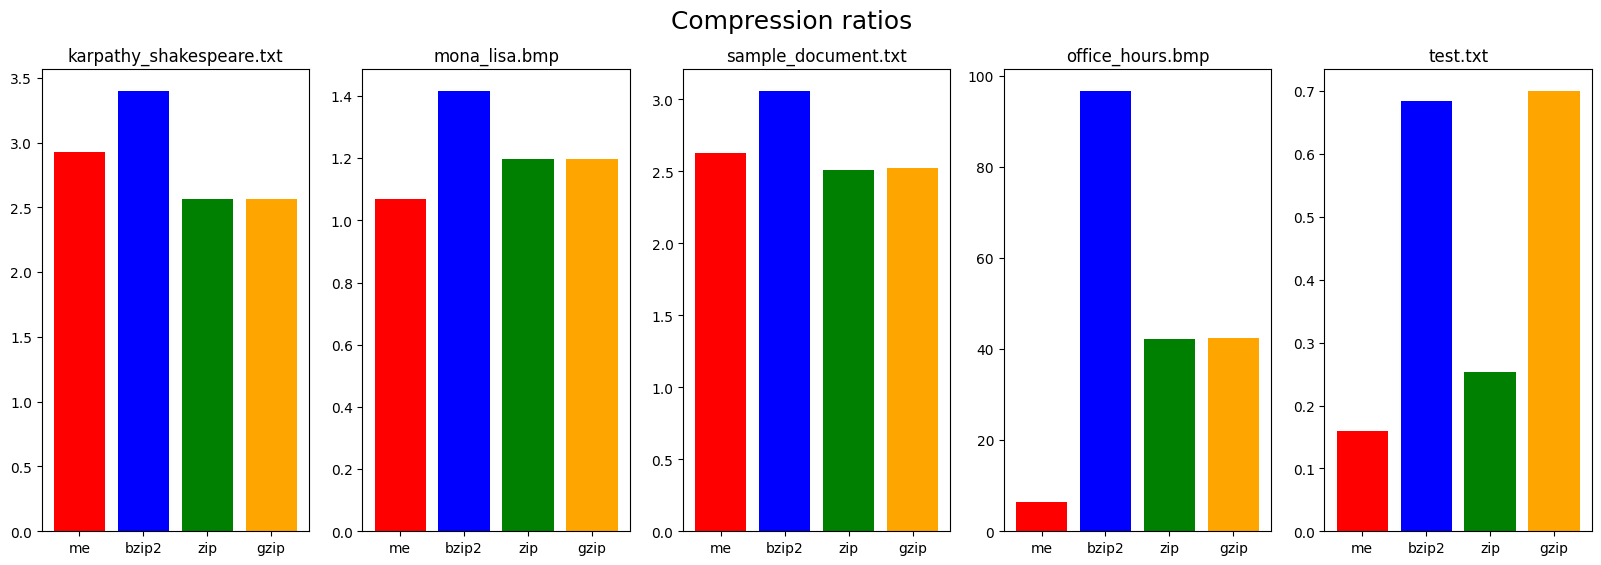

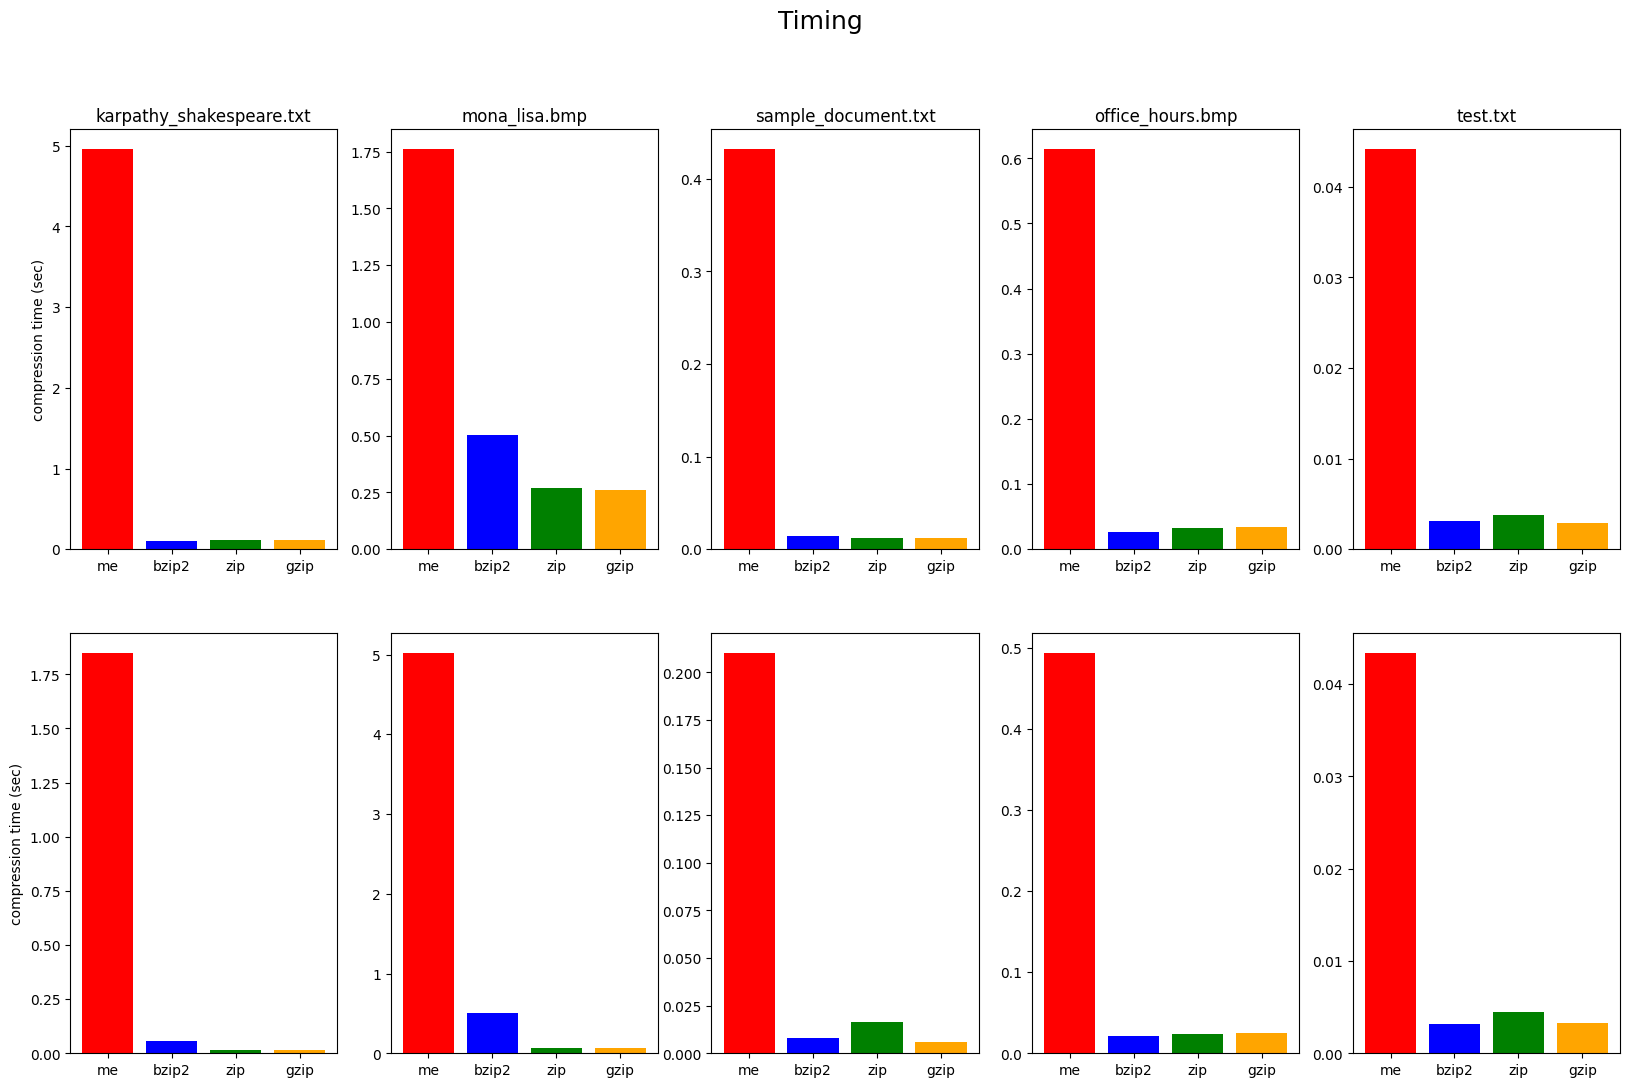

In [2]:
import matplotlib.pyplot as plt

data_dir = Path("test_data")
test_files = list(data_dir.iterdir())

compression_fig, compression_axs = plt.subplots(nrows=1, ncols=len(test_files), figsize=(20, 6))
timing_fig, timing_axs = plt.subplots(nrows=2, ncols=len(test_files), figsize=(20, 12))
colors = ["red", "blue", "green", "orange"]

for (i, file) in enumerate(test_files):
    filename = str(file)

    benches = {}
    benches["me"] = benchmark_my_compression(filename, binary=(file.suffix != ".txt"))
    benches["bzip2"] = benchmark_bzip2(filename)
    benches["zip"] = benchmark_zip(filename)
    benches["gzip"] = benchmark_gzip(filename)

    compression_axs[i].bar(benches.keys(), [benches[k][0] for k in benches.keys()], color=colors)
    compression_axs[i].set_title(file.name)

    for j in range(2):
        timing_axs[j, i].bar(benches.keys(), [benches[k][j + 1] for k in benches.keys()], color=colors)
        if j == 0:
            timing_axs[j, i].set_title(file.name)
        if i == 0:
            timing_axs[j, i].set_ylabel(f"{'' if i == 0 else 'de'}compression time (sec)")

viz_dir = Path("viz")
viz_dir.mkdir(exist_ok=True)

compression_fig.suptitle("Compression ratios", fontsize=18)
compression_fig.savefig(viz_dir / "compression_ratios.png")

timing_fig.suptitle("Timing", fontsize=18)
timing_fig.savefig(viz_dir / "timing.png")


Compressing: test_data/karpathy_shakespeare.txt
Running: python3 bwt_huffman.py -c -i test_data/karpathy_shakespeare.txt -o compressed.huff
Compression time: 5.322500467300415 sec
Running: python3 bwt_huffman.py -d -i compressed.huff -o decompressed.txt
Decompression time: 1.8695075511932373 sec
Original size: 1115393 bytes
Compressed size: 381367 bytes
Compression ratio: 2.924723429137812

Compressing: test_data/karpathy_shakespeare.txt
Running: python3 bwt_huffman.py -c -i test_data/karpathy_shakespeare.txt -o compressed.huff -b
Compression time: 0.3247647285461426 sec
Running: python3 bwt_huffman.py -d -i compressed.huff -o decompressed.txt -b
Decompression time: 0.750072717666626 sec
Original size: 1115393 bytes
Compressed size: 672474 bytes
Compression ratio: 1.6586410775732594

Compressing: test_data/sample_document.txt
Running: python3 bwt_huffman.py -c -i test_data/sample_document.txt -o compressed.huff
Compression time: 0.3449280261993408 sec
Running: python3 bwt_huffman.py -

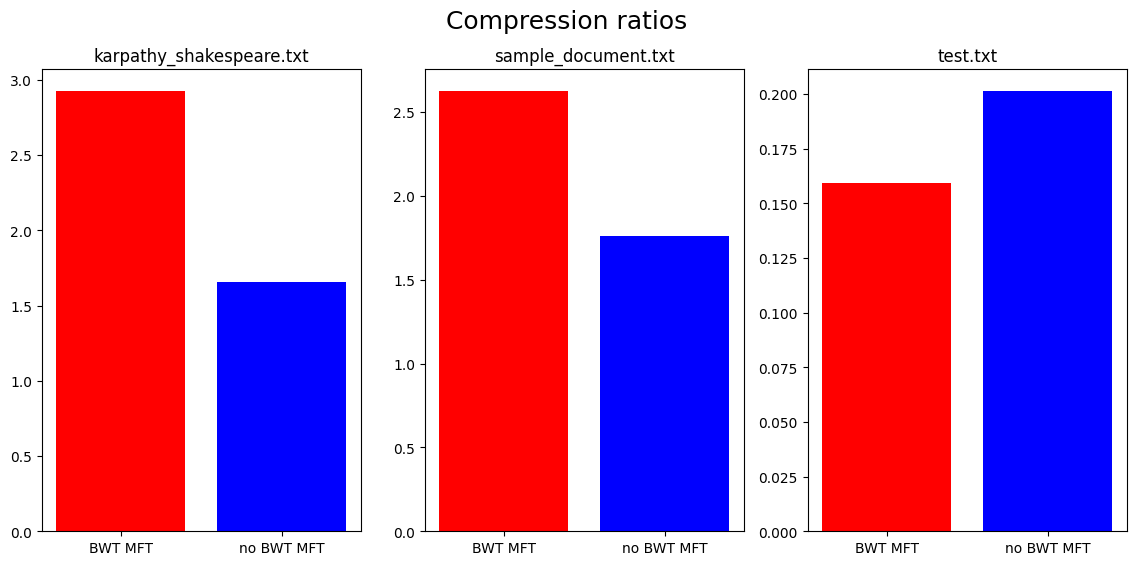

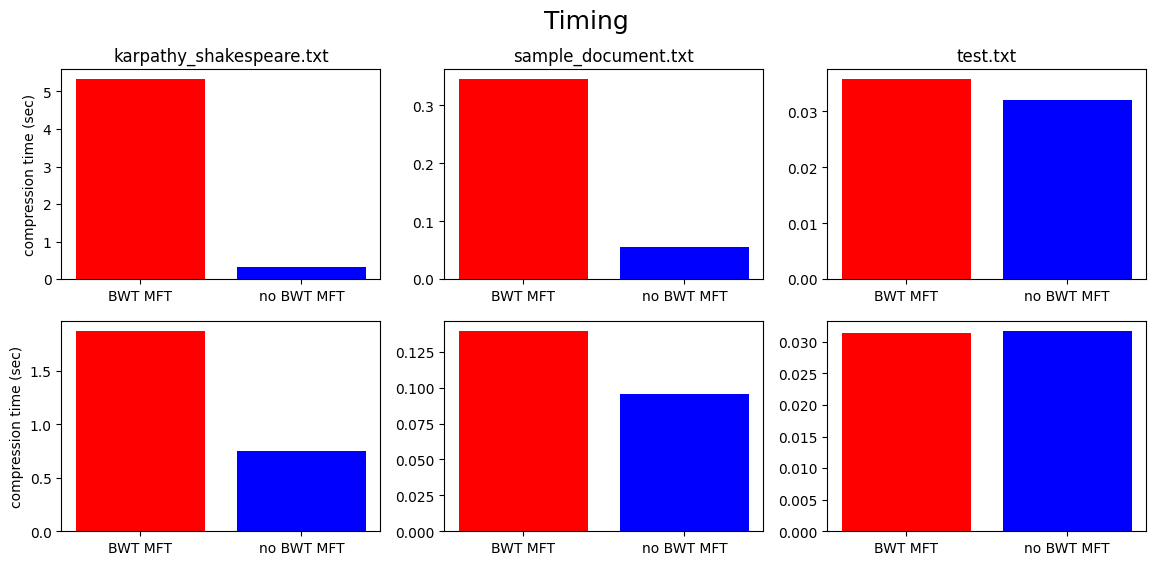

In [3]:
text_files = [file for file in test_files if file.suffix == ".txt"]

compression_fig, compression_axs = plt.subplots(nrows=1, ncols=len(text_files), figsize=(14, 6))
timing_fig, timing_axs = plt.subplots(nrows=2, ncols=len(text_files), figsize=(14, 6))
colors = ["red", "blue", "green", "orange"]

for (i, file) in enumerate(text_files):
    if file.suffix != ".txt":
        continue

    filename = str(file)
    use_bwt = benchmark_my_compression(filename, binary=False)
    no_bwt = benchmark_my_compression(filename, binary=True)
    benches = [use_bwt, no_bwt]

    bar_names = ["BWT MFT", "no BWT MFT"]
    compression_axs[i].bar(bar_names, [b[0] for b in benches], color=colors)
    compression_axs[i].set_title(file.name)

    for j in range(2):
        timing_axs[j, i].bar(bar_names, [b[j + 1] for b in benches], color=colors)
        if j == 0:
            timing_axs[j, i].set_title(file.name)
        if i == 0:
            timing_axs[j, i].set_ylabel(f"{'' if i == 0 else 'de'}compression time (sec)")

compression_fig.suptitle("Compression ratios", fontsize=18)
compression_fig.savefig(viz_dir / "bwt_compression_ratios.png")

timing_fig.suptitle("Timing", fontsize=18)
timing_fig.savefig(viz_dir / "bwt_timing.png")